In [ ]:
import pandas as pd
import re
import numpy as np
import networkx as nx
from nltk.corpus import stopwords
from nltk.tokenize import MWETokenizer #from course
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Natural language processing

In this notebook (NLP.ipynb) we, as the name implies, do the natural language processing part of the project. We make use of the same dataset as for the network analysis (filtered_emails.csv, see network.ipynb for more information). In our analysis we will be doing Sentiment analysis over time and TF-IDF unigrams and bigrams on the 10 highest betweenness (top hubs) and also on Kenneth Lay and Jeffrey Skilling.

## Why Track Sentiment Over Time and what we expect?

We apply sentiment analysis to our executive email subset because shifts in tone can serve as early warning signals of internal stress or crisis. By scoring each message’s sentiment polarity and aggregating those scores by month, we aim to:

1. **Detect Mood Swings**  
   Sudden dips in average sentiment may flag moments when leadership language turns cautious or negative—potentially preceding public revelations of trouble.

2. **Correlate with Network Dynamics**  
   Overlaying tone trends on our social‐network timeline lets us see whether changes in who is talking (centrality spikes) coincide with shifts in *how* they’re talking.

**What we expect to find**  
- A relatively flat, positive curve during normal operations.  
- Noticeable downward inflections around key events (e.g. auditor resignations, bankruptcy filings).  
- Divergences in tone among different hubs, revealing which individuals sensed trouble first.

This temporal sentiment lens complements our structural network measures, giving us a fuller picture of **who**, **when**, and **how** Enron’s leadership communicated as the company approached its collapse.


## Why Use TF–IDF Unigrams and Bigrams?

We leverage TF–IDF on both single words (unigrams) and two-word phrases (bigrams) to uncover the distinct topics each executive discusses:

- **Unigrams**  
  - Identify each hub’s core vocabulary—terms they use far more often than their peers.  
  - Provide a quick snapshot of domain areas (fx “trading,” “regulation,” “energy”) that drive their day-to-day work.  

- **Bigrams**  
  - Surface meaningful multi-word concepts that single tokens miss, such as “power trading,” “strategy meeting,” or “stock option.”  
  - Reveal the specific projects, partnerships, and technical terms at the heart of each executive’s emails.  

By analyzing unigrams and bigrams in our hubs’ emails, we’re looking for more than just job-related jargon—we want to surface **early linguistic signals of trouble** or potentially deceptive behavior. 

- **Unigram shifts**: If suddenly words like “audit,” “liability,” or “write-off” climb into the top ranks for a given executive—after months of stable, business-as-usual language—that may mark the first internal acknowledgment of financial or legal risk.  
- **Bigram anomalies**: Multi-word phrases such as “audit committee,” “insider trading,” or “liability cap” can pinpoint **specific issues** or cover-ups before those topics appear in public filings or leak into the media.  

Together, these term-frequency patterns give us a sort of “corporate lie detector,” flagging when routine communication gives way to crisis-driven vocabulary—potentially revealing the very moment when leaders began to grapple with or conceal the collapse that lay ahead.  


## The code

The code below is written with comments and a few print statements to help you understand what happens in each line. The analysis and discussion can be seen on our webpage.

## Preprocessing

In [25]:
# Load dataset
df = pd.read_csv('filtered_emails.csv')

# Build directed graph G
G = nx.DiGraph()
for _, row in df.iterrows():
    s, r, u = row['sender_code'], row['receiver_code'], row['user']
    if s == u:
        G.add_edge(u, r)
    elif r == u:
        G.add_edge(s, u)

# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Create DataFrame for centrality scores
bc_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness']).reset_index()
bc_df.rename(columns={'index': 'node'}, inplace=True)

# Sort by centrality and display top 10
top_n = bc_df.sort_values('betweenness', ascending=False).head(10)
print(top_n)


           node  betweenness
28       ward-k     0.109918
0     grigsby-m     0.073583
7    dasovich-j     0.066680
32     presto-k     0.066418
99      scott-s     0.065904
6    lavorato-j     0.062951
26    kitchen-l     0.057318
126     symes-k     0.057068
31   williams-j     0.046874
101    forney-j     0.040860


In [27]:
# Define your top-10 hub node codes
top_hubs = [
    'ward-k', 'grigsby-m', 'symes-k', 'scott-s',
    'presto-k', 'dasovich-j', 'lavorato-j',
    'kitchen-l', 'williams-j', 'forney-j'
]

# Subset to only the emails sent by those hubs
hub_emails = df[df['sender_code'].isin(top_hubs)]

# Inspect the result
print(f"Number of emails sent by top hubs: {hub_emails.shape[0]}\n")


Number of emails sent by top hubs: 3096



In [ ]:
hub_emails = df[df['sender_code'].isin(top_hubs)].copy()

# Prepare stopwords and any multi‐word expressions (MWEs) you care to catch
stop_words = set(stopwords.words('english'))
mwe_phrases = [('vice', 'president'), ('enron', 'corp')]
tokenizer = MWETokenizer(mwe_phrases, separator='_')

def preprocess_text(text):
    # lowercase & extract alphabetic tokens
    tokens = re.findall(r'\b[a-z]{2,}\b', text.lower())
    # stitch together any MWEs you've defined
    tokens = tokenizer.tokenize(tokens)
    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply to your hub subset
hub_emails['tokens'] = hub_emails['content'].fillna('').apply(preprocess_text)

# Sanity check
print("Example tokens for first email:", hub_emails['tokens'].iloc[0][:20])


Example tokens for first email: ['dear', 'west', 'talked', 'briefly', 'monday', 'commitment', 'full', 'work', 'day', 'enron', 'office', 'please', 'prepared', 'contribute', 'group', 'full', 'day', 'schedule', 'calls', 'critical']


## Sentiment analysis over time

In [39]:
# Parse dates
hub_emails['date'] = pd.to_datetime(hub_emails['date'])

# Compute sentiment with TextBlob
hub_emails['sentiment'] = (
    hub_emails['content']
      .fillna('')
      .apply(lambda txt: TextBlob(txt).sentiment.polarity)
)

# Simple regex‐tokenizer + stopword filter for tone
def simple_tokens(text):
    tokens = re.findall(r'\b[a-z]{2,}\b', text.lower())
    return [t for t in tokens if t not in ENGLISH_STOP_WORDS]

hub_emails['tokens'] = hub_emails['content'].fillna('').apply(simple_tokens)

# Lexical diversity as a “tone” proxy
hub_emails['lex_diversity'] = hub_emails['tokens'].apply(
    lambda toks: len(set(toks)) / len(toks) if toks else 0
)

# Aggregate by month
hub_emails.set_index('date', inplace=True)
sent_ts = hub_emails['sentiment'].resample('M').mean()
tone_ts = hub_emails['lex_diversity'].resample('M').mean()


C:\Users\sofus\AppData\Local\Temp\ipykernel_16800\1691746248.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sent_ts = hub_emails['sentiment'].resample('M').mean()
C:\Users\sofus\AppData\Local\Temp\ipykernel_16800\1691746248.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tone_ts = hub_emails['lex_diversity'].resample('M').mean()


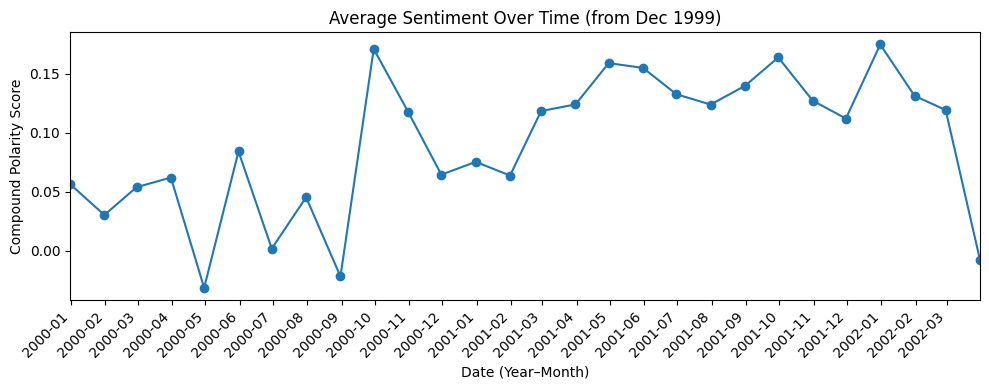

In [40]:
# Filter to December 1999 onward
sent_ts = sent_ts[sent_ts.index >= '1999-12-01']

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sent_ts.index, sent_ts.values, marker='o', linestyle='-')

# Zoom to your filtered range
ax.set_xlim(sent_ts.index.min(), sent_ts.index.max())

# Major ticks at the first of every month
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate labels
plt.setp(ax.get_xticklabels(which='major'), rotation=45, ha='right')

ax.set_title('Average Sentiment Over Time (from Dec 1999)')
ax.set_xlabel('Date (Year–Month)')
ax.set_ylabel('Compound Polarity Score')
plt.tight_layout()
plt.show()


C:\Users\sofus\AppData\Local\Temp\ipykernel_16800\2866840296.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'sender_code'])['sentiment']


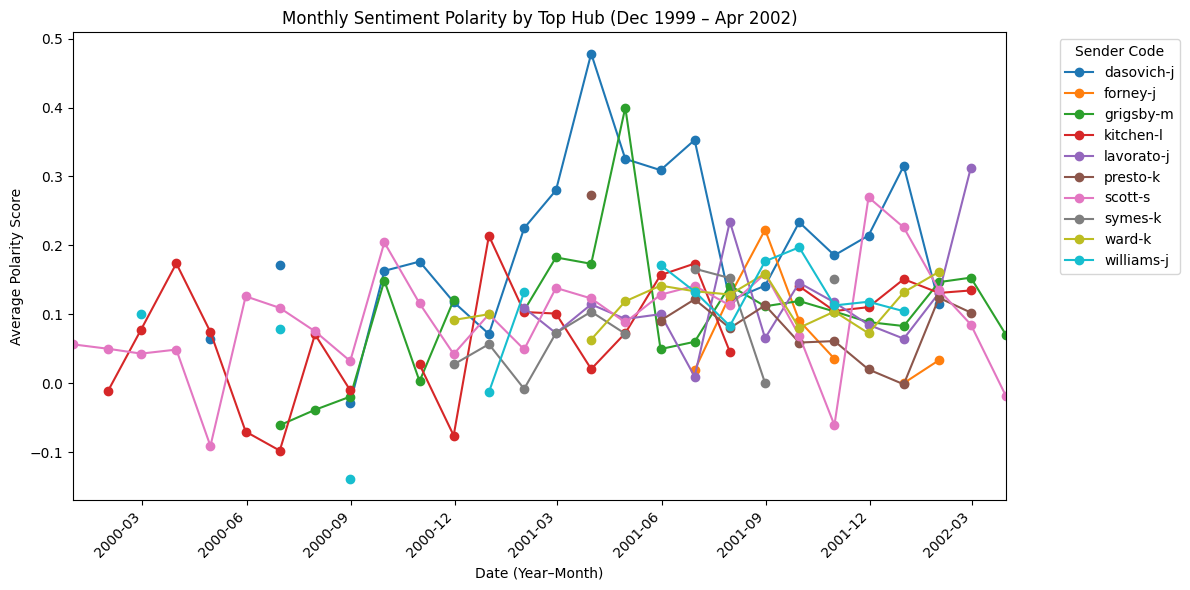

In [ ]:
hub_emails = df[df['sender_code'].isin(top_hubs)].copy()

# Parse dates and compute sentiment
hub_emails['date'] = pd.to_datetime(hub_emails['date'])
hub_emails['sentiment'] = hub_emails['content'].fillna('').apply(
    lambda txt: TextBlob(txt).sentiment.polarity
)

# Filter from December 1999 onward
hub_emails = hub_emails[hub_emails['date'] >= '1999-12-01']
hub_emails.set_index('date', inplace=True)

# Monthly average sentiment per hub
monthly_sent = (
    hub_emails
      .groupby([pd.Grouper(freq='M'), 'sender_code'])['sentiment']
      .mean()
      .unstack('sender_code')
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for hub in monthly_sent.columns:
    ax.plot(
        monthly_sent.index, 
        monthly_sent[hub], 
        marker='o', 
        linestyle='-',
        label=hub
    )

# Formatting: 3-month ticks
ax.set_xlim(monthly_sent.index.min(), monthly_sent.index.max())
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('Monthly Sentiment Polarity by Top Hub (Dec 1999 – Apr 2002)')
ax.set_xlabel('Date (Year–Month)')
ax.set_ylabel('Average Polarity Score')
ax.legend(title='Sender Code', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\sofus\AppData\Local\Temp\ipykernel_16800\2054428401.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lay_ts   = lay['sentiment'].resample('M').mean()
C:\Users\sofus\AppData\Local\Temp\ipykernel_16800\2054428401.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  skill_ts = skill['sentiment'].resample('M').mean()


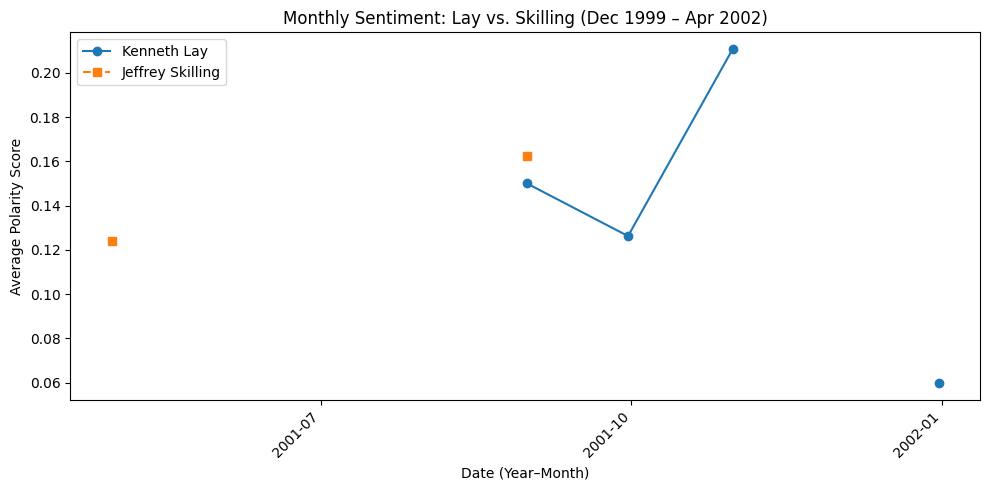

In [ ]:
# Lay’s and Skilling’s outgoing mail
lay = df[df['sender'].str.contains(r'\bLay\b', case=False, na=False)].copy()
skill = df[df['sender'].str.contains(r'\bSkill', case=False, na=False)].copy()

#Parse dates & compute TextBlob polarity
for subset in (lay, skill):
    subset['date'] = pd.to_datetime(subset['date'])
    subset['sentiment'] = subset['content'].fillna('').apply(
        lambda txt: TextBlob(txt).sentiment.polarity
    )

# Restrict to Dec 1999+ and aggregate by month
lay = lay[lay['date'] >= '1999-12-01'].set_index('date')
skill = skill[skill['date'] >= '1999-12-01'].set_index('date')

lay_ts   = lay['sentiment'].resample('M').mean()
skill_ts = skill['sentiment'].resample('M').mean()

# Plot both series side by side
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lay_ts.index,   lay_ts.values,   'o-', label='Kenneth Lay')
ax.plot(skill_ts.index, skill_ts.values, 's--', label='Jeffrey Skilling')

# Formatting: zoom to data range, quarterly ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('Monthly Sentiment: Lay vs. Skilling (Dec 1999 – Apr 2002)')
ax.set_xlabel('Date (Year–Month)')
ax.set_ylabel('Average Polarity Score')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Unigrams

In [ ]:
# Build one “document” per hub
docs = hub_emails.groupby('sender_code')['content'] \
                 .apply(lambda texts: " ".join(texts.fillna("")))

# Remove only boilerplate words
boilerplate = {'ees','ect','hou','enron','com','fw','pm','subject','message','original','sent'}
stop_words = list(ENGLISH_STOP_WORDS.union(boilerplate))

# Fit a bigram TF–IDF
vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    token_pattern=r'\b[a-z]{2,}\b',
    ngram_range=(2,2),
    max_features=2000
)
tfidf = vectorizer.fit_transform(docs)
features = vectorizer.get_feature_names_out()

# Pull out each hub’s top 10 bigrams
top_n = 10
results = []
for i, hub in enumerate(docs.index):
    row = tfidf[i].toarray().flatten()
    best = row.argsort()[-top_n:][::-1]
    terms = [features[j] for j in best]
    results.append({'hub': hub, 'top_10_bigrams': ", ".join(terms)})

# Show as a table
import pandas as pd
pd.DataFrame(results)


,hub,top_10_bigrams
0,dasovich-j,"best jeff, jeff dasovich, dasovich jeff, direc..."
1,forney-j,"forney john, phone numbers, gilbert smith, wed..."
2,grigsby-m,"grigsby mike, mvc jpg, thanks mike, mike grigs..."
3,kitchen-l,"louise kitchen, dkrunnfusz agency, kitchen lou..."
4,lavorato-j,"lavorato john, kitchen louise, bc hydro, john ..."
5,presto-k,"presto kevin, lavorato john, kitchen louise, h..."
6,scott-s,"susan scott, et cc, drew fossum, scott susan, ..."
7,symes-k,"kate symes, symes pdx, pdx cc, cara semperger,..."
8,ward-k,"ward kim, kim ward, thanks kim, kim houston, m..."
9,williams-j,"jaime williams, louis dreyfus, covers physical..."


We see that names overflow the results and decide to remove them since its not what we want to find. Even though names can give us an insight to who is talking to who, we felt like the network already did this. In the NLP part we focus more the underlying topics of each hub

In [48]:

# One “document” per hub
docs = hub_emails.groupby('sender_code')['content']\
                 .apply(lambda txts: " ".join(txts.fillna("")))

# Build a custom stop‐list
names = {
    'jeff','dasovich','mike','grigsby','john','louise','kevin',
    'presto','susan','scott','drew','fossum','kate','symes',
    'cara','kim','ward','jaime','williams','sara','chris'
}
codes = {
    'ees','ect','hou','ercot','isda','pdx','cc','cn','tw',
    'dwr','da','npca','ubsw','vpp','pm','fw',
    'subject','message','original','sent', 'jrw',
    'com', 'mvc', 'puc', 'enron', 'jpg', 'igs'
}
stop_words = list(ENGLISH_STOP_WORDS.union(names).union(codes))

# TF–IDF on unigrams
vec = TfidfVectorizer(
    stop_words=stop_words,
    token_pattern=r'\b[a-z]{3,}\b',  # ignore 1–2 letter artifacts
    max_features=2000
)
tfidf = vec.fit_transform(docs)
terms = vec.get_feature_names_out()

# Print top 10 per hub
top_n = 10
for hub, row in zip(docs.index, tfidf.toarray()):
    idxs = row.argsort()[-top_n:][::-1]
    print(f"{hub}: {', '.join(terms[i] for i in idxs)}")

dasovich-j: edison, california, assembly, power, state, said, davis, best, senate, energy
forney-j: texas, smith, address, load, thanks, numbers, control, know, working, august
grigsby-m: mail, gas, thanks, know, afghanistan, let, meeting, taleban, october, tuesday
kitchen-l: kitchen, fastow, agency, dkrunnfusz, lon, stock, company, said, partnerships, david
lavorato-j: lavorato, gas, var, kitchen, delainey, enronxgate, october, think, greg, tuesday
presto-k: vepco, lavorato, ubs, trading, day, hourly, energy, power, think, new
scott-s: transwestern, rate, know, agreement, tariff, ferc, commission, gas, kholst, mary
symes-k: deal, deals, semperger, kroum, dow, like, thanks, jones, know, let
ward-k: gas, thanks, know, houston, srpnet, agreement, let, marussel, master, shackleton
williams-j: gas, ncpa, monterrey, thanks, credit, energy, trading, mexico, physical, covers


In [ ]:
# Filter for Kenneth Lay and Jeffrey Skilling
lay_df = df[df['sender'].str.contains(r'\bLay\b', case=False, na=False)]
skill_df = df[df['sender'].str.contains(r'\bSkill\b', case=False, na=False)]

# Build “documents” by concatenating all their emails
docs = pd.Series({
    'Kenneth Lay': " ".join(lay_df['content'].fillna("")),
    'Jeffrey Skilling': " ".join(skill_df['content'].fillna(""))
})

# Define stopwords
extra = {
    'enron','com','subject','message','original','sent','fw','pm'
}
stop_words = list(ENGLISH_STOP_WORDS.union(extra))

# Fit a TF–IDF vectorizer on those 2 docs
vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    token_pattern=r'\b[a-z]{3,}\b',  # words ≥3 letters
    max_features=500
)
tfidf = vectorizer.fit_transform(docs)
terms = vectorizer.get_feature_names_out()

# Print the top 10 TF–IDF terms per person
top_n = 10
for person, row in zip(docs.index, tfidf.toarray()):
    idxs = row.argsort()[-top_n:][::-1]
    top_terms = [terms[i] for i in idxs]
    print(f"{person}: {', '.join(top_terms)}")

Kenneth Lay: stock, grant, company, group, lay, doing, trading, years, monday, meeting
Jeffrey Skilling: zero, hope, glad, goal, goes, going, good, goode, governors, grant


## Bigrams

In [ ]:

# Build one “document” per hub
docs = hub_emails.groupby('sender_code')['content'] \
                 .apply(lambda texts: " ".join(texts.fillna("")))

# Create a stop-list (generic + names + corporate acronyms)
names = {'jeff','dasovich','mike','grigsby','john','louise','kevin',
         'presto','susan','scott','drew','fossum','kate','symes',
         'cara','kim','ward','jaime','williams','sara','chris','lay','skilling'
         'steffes','james','gilbert','smith','david','krunnfusz',
    'tim','belden','stacey','white','mary','kay','kholst','keith'}
acronyms = {'enron','com','fw','pm','ees','ect','hou','ercot','puc','dwr','npca','ubsw','srpnet'}
boiler = {'subject','message','original','sent','re','fw'}
codes = {
    'ees','ect','hou','ercot','isda','pdx','cc','cn','tw',
    'dwr','da','npca','ubsw','vpp','pm','fw',
    'subject','message','original','sent', 'jrw',
    'com', 'mvc', 'puc', 'enron', 'jpg', 'igs'
}
stop_words = list(ENGLISH_STOP_WORDS.union(names).union(acronyms).union(boiler).union(codes))

# Fit TF–IDF for bigrams
vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    token_pattern=r'\b[a-z]{3,}\b',  # only words >=3 letters
    ngram_range=(2,2),
    max_features=2000
)
tfidf = vectorizer.fit_transform(docs)
terms = vectorizer.get_feature_names_out()

# Extract and print top 5 bigrams per hub
top_n = 5
for hub, row in zip(docs.index, tfidf.toarray()):
    idxs = row.argsort()[-top_n:][::-1]
    top_terms = [terms[i] for i in idxs]
    print(f"{hub}: {', '.join(top_terms)}")


dasovich-j: direct access, power authority, cpuc gov, richard shapiro, stranded costs
forney-j: phone numbers, wednesday september, monday august, real time, herndon rogers
grigsby-m: strategy meeting, fundamental analysis, analysis strategy, file attached, portland fundamental
kitchen-l: dkrunnfusz agency, kitchen lon, forwarded kitchen, dow jones, wall street
lavorato-j: epmi short, issue comes, october lavorato, epmi long, november lavorato
presto-k: hourly index, new albany, meeting vepco, loss calc, non delivery
scott-s: negotiated rate, recipients date, holst recipients, attachment follows, inline attachment
symes-k: dow jones, cross portfolio, jones index, index prices, database access
ward-k: master purchase, sale agreement, let know, purchase sale, city glendale
williams-j: louis dreyfus, covers physical, financial trading, best regards, natural gas


In [ ]:
# Filter for Lay and Skilling
lay_df   = df[df['sender'].str.contains(r'\bLay\b',   case=False, na=False)]
skill_df = df[df['sender'].str.contains(r'\bSkill\b', case=False, na=False)]

# Build one “document” per person
docs = pd.Series({
    'Kenneth Lay':   " ".join(lay_df['content'].fillna("")),
    'Jeffrey Skilling': " ".join(skill_df['content'].fillna(""))
})

# Create a stop‐list (generic + boilerplate)
extra = {'enron','com','subject','message','original','sent','fw','pm', 'haven', 'lay'}
stop_words = list(ENGLISH_STOP_WORDS.union(extra))

# Fit TF–IDF on bigrams
vec = TfidfVectorizer(
    stop_words=stop_words,
    token_pattern=r'\b[a-z]{3,}\b',
    ngram_range=(2,2),
    max_features=500
)
tfidf = vec.fit_transform(docs)
bigrams = vec.get_feature_names_out()

# Extract top 5 bigrams per executive
top_n = 5
for person, row in zip(docs.index, tfidf.toarray()):
    idxs = row.argsort()[-top_n:][::-1]
    best = [bigrams[i] for i in idxs]
    print(f"{person}: {', '.join(best)}")

Kenneth Lay: stock option, power trading, trading group, quarterly basis, forward seeing
Jeffrey Skilling: yes understand, hendrickson free, group yes, guy sounds, happening ken
